Valor esperado por acción:
- GASTAR   : 100.00
- AHORRAR  : 103.00
- INVERTIR : 104.00

Mejor acción según valor esperado: INVERTIR (VE = 104.00)


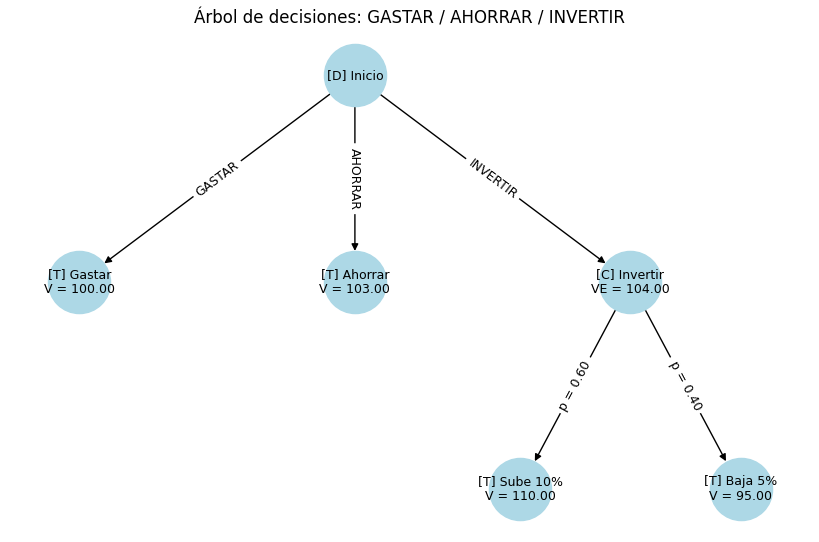

Ruta greedy: INVERTIR
Utilidad esperada de la ruta: 104.00


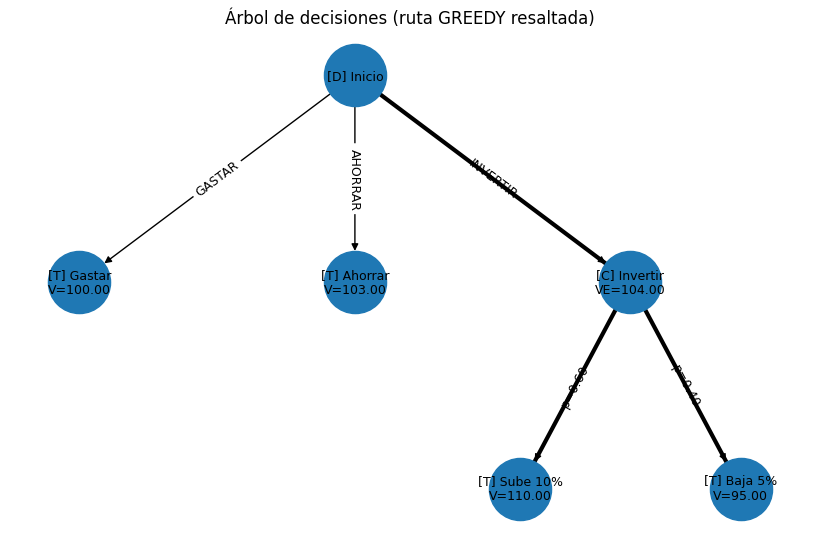


-- Caso 1: Greedy puro (epsilon=0.0, lambda=0.0) --
=== Resumen ===
Episodios: 100
Cuenta acciones: {'GASTAR': 0, 'AHORRAR': 0, 'INVERTIR': 100}
Pago promedio por episodio: 105.05
Posterior p_up_est ~ Beta(a=73.0, b=37.0) => media 0.664
INVERTIR: VE(teórico con posterior)=104.95, sigma_teórica=7.09
INVERTIR: sigma_observada=7.09
Política: epsilon=0.0, risk_lambda=0.0

-- Caso 2: ε-greedy y riesgo (epsilon=0.05, lambda=0.5) --
=== Resumen ===
Episodios: 300
Cuenta acciones: {'GASTAR': 6, 'AHORRAR': 292, 'INVERTIR': 2}
Pago promedio por episodio: 102.99
Posterior p_up_est ~ Beta(a=8.0, b=4.0) => media 0.667
INVERTIR: VE(teórico con posterior)=105.00, sigma_teórica=7.07
INVERTIR: sigma_observada=0.00
Política: epsilon=0.05, risk_lambda=0.5


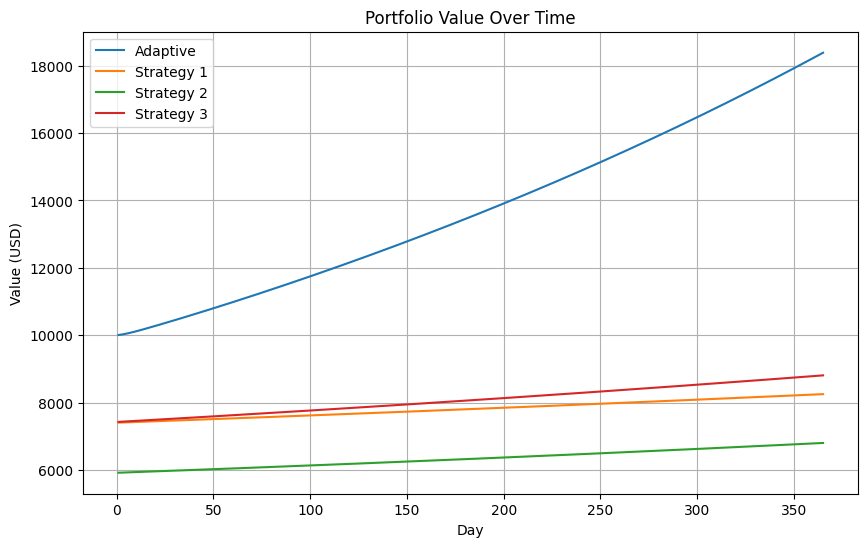

In [1]:
from dataclasses import dataclass
from typing import Dict, Callable, List, Tuple, Optional

# --- Nodos base ---
class Node:
    def value(self) -> float:
        raise NotImplementedError

@dataclass
class DecisionNode(Node):
    """Nodo de decisión: eliges una acción entre hijos."""
    children: Dict[str, Node]  # acción -> subárbol
    policy: Optional[Callable[[Dict[str, Node]], str]] = None  # regla para elegir acción

    def value(self) -> float:
        # Si hay política, úsala; si no, elige el hijo con mayor valor esperado
        if self.policy:
            choice = self.policy(self.children)
            return self.children[choice].value()
        # Política por defecto: maximizar valor
        best = max(self.children.items(), key=lambda kv: kv[1].value())
        return best[1].value()

    def best_action(self) -> Tuple[str, float]:
        vals = {a: n.value() for a, n in self.children.items()}
        a_best = max(vals, key=vals.get)
        return a_best, vals[a_best]

@dataclass
class ChanceNode(Node):
    """Nodo de azar: mezcla de resultados con probabilidades."""
    outcomes: List[Tuple[float, Node]]  # (probabilidad, hijo)

    def value(self) -> float:
        return sum(p * child.value() for p, child in self.outcomes)

@dataclass
class Terminal(Node):
    """Resultado final (utilidad o dinero)."""
    payoff: float
    def value(self) -> float:
        return self.payoff

# --- Ejemplo: decidir entre GASTAR, AHORRAR o INVERTIR ---
# Supongamos que hoy tienes 100. Tres acciones:
# 1) GASTAR: utilidad inmediata 100 (no crece).
# 2) AHORRAR: depósito al 3% seguro.
# 3) INVERTIR: 60% sube 10%, 40% baja 5%.

# Parámetros
capital_inicial = 100
r_ahorro = 0.03
r_up, p_up = 0.10, 0.60
r_down, p_down = -0.05, 0.40

# Hojas (terminales)
gastar = Terminal(payoff=capital_inicial)                      # utilidad directa
ahorrar = Terminal(payoff=capital_inicial * (1 + r_ahorro))    # seguro 3%
invertir = ChanceNode(outcomes=[
    (p_up,   Terminal(payoff=capital_inicial * (1 + r_up))),
    (p_down, Terminal(payoff=capital_inicial * (1 + r_down))),
])

raiz = DecisionNode(children={
    "GASTAR": gastar,
    "AHORRAR": ahorrar,
    "INVERTIR": invertir
})

# Resultados
print("Valor esperado por acción:")
for a, node in raiz.children.items():
    print(f"- {a:<9}: {node.value():.2f}")

best, v = raiz.best_action()
print(f"\nMejor acción según valor esperado: {best} (VE = {v:.2f})")

import matplotlib.pyplot as plt
import networkx as nx

# --- Definición de nodos y cálculo ---
capital_inicial = 100
r_ahorro = 0.03
r_up, p_up = 0.10, 0.60
r_down, p_down = -0.05, 0.40

# Valores terminales
V_gastar = capital_inicial
V_ahorrar = capital_inicial * (1 + r_ahorro)
V_invertir_up = capital_inicial * (1 + r_up)
V_invertir_down = capital_inicial * (1 + r_down)

# Valor esperado de invertir
V_invertir = p_up * V_invertir_up + p_down * V_invertir_down

# --- Construcción del grafo ---
G = nx.DiGraph()

# Nodos: etiqueta incluye tipo de nodo y valor
G.add_node("root", label="[D] Inicio")
G.add_node("gastar", label=f"[T] Gastar\nV = {V_gastar:.2f}")
G.add_node("ahorrar", label=f"[T] Ahorrar\nV = {V_ahorrar:.2f}")
G.add_node("invertir", label=f"[C] Invertir\nVE = {V_invertir:.2f}")
G.add_node("up", label=f"[T] Sube 10%\nV = {V_invertir_up:.2f}")
G.add_node("down", label=f"[T] Baja 5%\nV = {V_invertir_down:.2f}")

# Aristas con etiquetas
G.add_edge("root", "gastar", label="GASTAR")
G.add_edge("root", "ahorrar", label="AHORRAR")
G.add_edge("root", "invertir", label="INVERTIR")
G.add_edge("invertir", "up", label=f"p = {p_up:.2f}")
G.add_edge("invertir", "down", label=f"p = {p_down:.2f}")

# --- Layout y dibujo ---
pos = {
    "root": (0, 2),
    "gastar": (-2, 1),
    "ahorrar": (0, 1),
    "invertir": (2, 1),
    "up": (1.2, 0),
    "down": (2.8, 0),
}

plt.figure(figsize=(8, 5))
nx.draw(G, pos, with_labels=False, node_size=2000, node_color="lightblue")

# Etiquetas de nodos
node_labels = {n: d["label"] for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9)

# Etiquetas de aristas
edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Árbol de decisiones: GASTAR / AHORRAR / INVERTIR")
plt.axis("off")
plt.show()

# --- Árbol de decisiones con búsqueda GREEDY por utilidad esperada ---
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

# ------------------------------
# Definición de nodos del árbol
# ------------------------------
class Node:
    def value(self) -> float:
        raise NotImplementedError

@dataclass
class Terminal(Node):
    payoff: float
    def value(self) -> float:
        return float(self.payoff)

@dataclass
class ChanceNode(Node):
    # Lista de (probabilidad, hijo)
    outcomes: List[Tuple[float, Node]]
    def value(self) -> float:
        return sum(p * child.value() for p, child in self.outcomes)

@dataclass
class DecisionNode(Node):
    # acción -> subárbol
    children: Dict[str, Node]
    def value(self) -> float:
        # Valor de este nodo si se elige óptimo (no lo usa la greedy en sí)
        return max(child.value() for child in self.children.values())

# ---------------------------------------
# Búsqueda greedy (codiciosa) en el árbol
# ---------------------------------------
def greedy_search(root: Node) -> Tuple[List[str], float]:
    """
    Recorre el árbol eligiendo en cada DecisionNode el hijo con MAYOR utilidad esperada.
    En ChanceNode no se elige; se toma su valor esperado y se detiene (o se podría expandir).
    Devuelve (ruta_de_acciones, utilidad_esperada_total).
    """
    actions: List[str] = []
    node = root

    while True:
        if isinstance(node, DecisionNode):
            # Elegir la acción con mayor utilidad esperada inmediata
            best_action, best_child = max(
                node.children.items(), key=lambda kv: kv[1].value()
            )
            actions.append(best_action)
            node = best_child
            continue

        elif isinstance(node, ChanceNode):
            # No hay decisión; devolvemos la utilidad esperada del azar
            return actions, node.value()

        elif isinstance(node, Terminal):
            # Llegamos a un resultado final
            return actions, node.value()

        else:
            raise TypeError("Tipo de nodo desconocido")

# ------------------------------
# Ejemplo: gastar / ahorrar / invertir
# ------------------------------
capital_inicial = 100
r_ahorro = 0.03
r_up, p_up = 0.10, 0.60
r_down, p_down = -0.05, 0.40

gastar = Terminal(capital_inicial)
ahorrar = Terminal(capital_inicial * (1 + r_ahorro))
invertir = ChanceNode([
    (p_up,   Terminal(capital_inicial * (1 + r_up))),
    (p_down, Terminal(capital_inicial * (1 + r_down))),
])

raiz = DecisionNode({
    "GASTAR": gastar,
    "AHORRAR": ahorrar,
    "INVERTIR": invertir
})

# Ejecutar greedy
ruta, utilidad = greedy_search(raiz)
print("Ruta greedy:", " -> ".join(ruta) if ruta else "(sin acciones)")
print(f"Utilidad esperada de la ruta: {utilidad:.2f}")

# ------------------------------
# (Opcional) Graficar resaltando la ruta greedy
# ------------------------------
try:
    import networkx as nx
    import matplotlib.pyplot as plt

    # Construcción de grafo para visualización
    G = nx.DiGraph()
    G.add_node("root", label="[D] Inicio")
    G.add_node("gastar", label=f"[T] Gastar\nV={gastar.value():.2f}")
    G.add_node("ahorrar", label=f"[T] Ahorrar\nV={ahorrar.value():.2f}")
    G.add_node("invertir", label=f"[C] Invertir\nVE={invertir.value():.2f}")
    # Hijos de invertir
    V_up = capital_inicial * (1 + r_up)
    V_down = capital_inicial * (1 + r_down)
    G.add_node("up", label=f"[T] Sube 10%\nV={V_up:.2f}")
    G.add_node("down", label=f"[T] Baja 5%\nV={V_down:.2f}")

    # Aristas
    G.add_edge("root", "gastar", label="GASTAR")
    G.add_edge("root", "ahorrar", label="AHORRAR")
    G.add_edge("root", "invertir", label="INVERTIR")
    G.add_edge("invertir", "up", label=f"p={p_up:.2f}")
    G.add_edge("invertir", "down", label=f"p={p_down:.2f}")

    # Posiciones
    pos = {
        "root": (0, 2),
        "gastar": (-2, 1),
        "ahorrar": (0, 1),
        "invertir": (2, 1),
        "up": (1.2, 0),
        "down": (2.8, 0),
    }

    # Dibujo base
    plt.figure(figsize=(8, 5))
    nx.draw(G, pos, with_labels=False, node_size=2000)

    # Etiquetas
    nx.draw_networkx_labels(G, pos, labels={n: d["label"] for n, d in G.nodes(data=True)}, font_size=9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d["label"] for u, v, d in G.edges(data=True)}, font_size=9)

    # Resaltar la ruta greedy
    greedy_edges = []
    if ruta and ruta[0] == "GASTAR":
        greedy_edges = [("root", "gastar")]
    elif ruta and ruta[0] == "AHORRAR":
        greedy_edges = [("root", "ahorrar")]
    elif ruta and ruta[0] == "INVERTIR":
        greedy_edges = [("root", "invertir"), ("invertir", "up"), ("invertir", "down")]  # azar (se muestra completo)

    nx.draw_networkx_edges(G, pos, edgelist=greedy_edges, width=3)

    plt.title("Árbol de decisiones (ruta GREEDY resaltada)")
    plt.axis("off")
    plt.show()
except Exception as e:
    print("No se pudo graficar (opcional):", e)

from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import random
import math

# ==============================
#   1) Nodos del árbol
# ==============================
class Node:
    def value(self) -> float:
        raise NotImplementedError

@dataclass
class Terminal(Node):
    payoff: float
    def value(self) -> float:
        return float(self.payoff)

@dataclass
class ChanceNode(Node):
    # outcomes: lista de (probabilidad, hijo)
    outcomes: List[Tuple[float, Node]]
    def value(self) -> float:
        return sum(p * child.value() for p, child in self.outcomes)

@dataclass
class DecisionNode(Node):
    children: Dict[str, Node]
    def value(self) -> float:
        return max(child.value() for child in self.children.values())

# ==============================
#   2) Modelo adaptativo
# ==============================
class AdaptiveInvestModel:
    """
    Estima p_up de INVERTIR con una distribución Beta(a, b).
    Permite decisión greedy/epsilon-greedy y (opcional) ajuste por riesgo.
    """
    def __init__(self,
                 capital_inicial=100.0,
                 r_ahorro=0.03,
                 gain_up=0.10,
                 loss_down=-0.05,
                 beta_a=6.0, beta_b=4.0,       # prior: media 0.6 (puedes cambiarlo)
                 epsilon=0.0,                  # 0 = greedy puro, >0 = ε-greedy
                 risk_lambda=0.0):             # penaliza desviación estándar
        self.C0 = float(capital_inicial)
        self.r_ahorro = float(r_ahorro)
        self.gain_up = float(gain_up)
        self.loss_down = float(loss_down)
        self.a = float(beta_a)
        self.b = float(beta_b)
        self.epsilon = float(epsilon)
        self.risk_lambda = float(risk_lambda)

        # Estadísticas online (Welford) para la varianza observada de INVERTIR
        self.n_invest = 0
        self.mean_invest = 0.0
        self.M2_invest = 0.0  # sum of squares of differences

        # Trazas
        self.history = []

    # --- Probabilidad posterior de "sube" ---
    def p_up_est(self) -> float:
        return self.a / (self.a + self.b)

    # --- Valor esperado y sigma de INVERTIR dados los parámetros actuales ---
    def investir_stats(self) -> Tuple[float, float]:
        p = self.p_up_est()
        v_up = self.C0 * (1.0 + self.gain_up)
        v_dn = self.C0 * (1.0 + self.loss_down)
        ve = p * v_up + (1 - p) * v_dn

        # Desviación estándar teórica de la lotería binaria (para penalización opcional)
        mu = ve
        var = p * (v_up - mu)**2 + (1 - p) * (v_dn - mu)**2
        sigma = math.sqrt(var)
        return ve, sigma

    # --- Valor de cada acción bajo la métrica elegida ---
    def action_values(self) -> Dict[str, float]:
        gastar = self.C0
        ahorrar = self.C0 * (1.0 + self.r_ahorro)
        ve_inv, sigma_inv = self.investir_stats()
        score_inv = ve_inv - self.risk_lambda * sigma_inv
        return {
            "GASTAR": gastar,
            "AHORRAR": ahorrar,
            "INVERTIR": score_inv
        }

    # --- Política de decisión (ε-greedy opcional) ---
    def choose_action(self) -> str:
        if random.random() < self.epsilon:
            return random.choice(["GASTAR", "AHORRAR", "INVERTIR"])
        vals = self.action_values()
        return max(vals.items(), key=lambda kv: kv[1])[0]

    # --- Actualización bayesiana con un resultado real de INVERTIR ---
    def update_invest(self, went_up: bool, payoff: float):
        # Beta posterior
        if went_up:
            self.a += 1.0
        else:
            self.b += 1.0

        # Welford para sigma observada
        self.n_invest += 1
        delta = payoff - self.mean_invest
        self.mean_invest += delta / self.n_invest
        delta2 = payoff - self.mean_invest
        self.M2_invest += delta * delta2

    # --- Sigma observada por datos (por si prefieres riesgo empírico) ---
    def observed_sigma_invest(self) -> float:
        if self.n_invest < 2:
            return 0.0
        return math.sqrt(self.M2_invest / (self.n_invest - 1))

# ==============================
#   3) Simulador (reemplázalo por datos reales si quieres)
# ==============================
class Environment:
    """
    Simula el mundo verdadero. Puedes fijar p_up_true (desconocido para el agente).
    Reemplázalo por tus observaciones reales y llama model.update_invest(...)
    """
    def __init__(self, capital_inicial=100.0, r_ahorro=0.03,
                 gain_up=0.10, loss_down=-0.05, p_up_true=0.60):
        self.C0 = float(capital_inicial)
        self.r_ahorro = float(r_ahorro)
        self.gain_up = float(gain_up)
        self.loss_down = float(loss_down)
        self.p_up_true = float(p_up_true)

    def step(self, action: str) -> Tuple[float, Optional[bool]]:
        if action == "GASTAR":
            return self.C0, None
        if action == "AHORRAR":
            return self.C0 * (1.0 + self.r_ahorro), None
        if action == "INVERTIR":
            went_up = random.random() < self.p_up_true
            payoff = self.C0 * (1.0 + (self.gain_up if went_up else self.loss_down))
            return payoff, went_up
        raise ValueError("Acción desconocida")

# ==============================
#   4) Bucle de aprendizaje
# ==============================
def run_learning(episodes=200,
                 epsilon=0.05,
                 risk_lambda=0.0,
                 prior=(6.0, 4.0),
                 p_up_true=0.60):
    model = AdaptiveInvestModel(beta_a=prior[0], beta_b=prior[1],
                                epsilon=epsilon, risk_lambda=risk_lambda)
    env = Environment(p_up_true=p_up_true)

    counts = {"GASTAR": 0, "AHORRAR": 0, "INVERTIR": 0}
    total_payoff = 0.0

    for t in range(1, episodes + 1):
        action = model.choose_action()
        payoff, went_up = env.step(action)
        counts[action] += 1
        total_payoff += payoff

        # Si invertimos, actualizamos posterior con el resultado observado
        if action == "INVERTIR":
            model.update_invest(went_up=bool(went_up), payoff=payoff)

        # Guarda trazas simples
        vals = model.action_values()
        model.history.append({
            "t": t,
            "action": action,
            "payoff": payoff,
            "p_up_est": model.p_up_est(),
            "vals": vals
        })

    avg_payoff = total_payoff / episodes
    ve_inv, sigma_inv = model.investir_stats()

    print("=== Resumen ===")
    print(f"Episodios: {episodes}")
    print(f"Cuenta acciones: {counts}")
    print(f"Pago promedio por episodio: {avg_payoff:.2f}")
    print(f"Posterior p_up_est ~ Beta(a={model.a:.1f}, b={model.b:.1f}) => media {model.p_up_est():.3f}")
    print(f"INVERTIR: VE(teórico con posterior)={ve_inv:.2f}, sigma_teórica={sigma_inv:.2f}")
    print(f"INVERTIR: sigma_observada={model.observed_sigma_invest():.2f}")
    print(f"Política: epsilon={model.epsilon}, risk_lambda={model.risk_lambda}")
    return model

# ==============================
#   5) Ejecución de ejemplo
# ==============================
if __name__ == "__main__":
    # Caso 1: greedy puro (sin exploración, sin riesgo)
    print("\n-- Caso 1: Greedy puro (epsilon=0.0, lambda=0.0) --")
    _ = run_learning(episodes=100, epsilon=0.0, risk_lambda=0.0, p_up_true=0.60)

    # Caso 2: ε-greedy y penalización por riesgo
    print("\n-- Caso 2: ε-greedy y riesgo (epsilon=0.05, lambda=0.5) --")
    _ = run_learning(episodes=300, epsilon=0.05, risk_lambda=0.5, p_up_true=0.60)

import random
import numpy as np
import pandas as pd

# Initial capital
INITIAL_CAPITAL = 10000

# Asset pools
STOCKS = ['AAPL', 'TSLA', 'AMZN', 'GOOGL', 'MSFT', 'NVDA', 'META', 'NFLX', 'JPM', 'V']
CRYPTOS = ['BTC', 'ETH', 'SOL', 'ADA', 'BNB', 'XRP']

# Simulate asset returns (annualized)
def simulate_asset_returns(assets: list, volatility: float = 0.25) -> dict:
    returns = {}
    for asset in assets:
        mean_return = random.uniform(0.05, 0.15)
        simulated = np.random.normal(loc=mean_return, scale=volatility)
        returns[asset] = round(simulated, 4)
    return returns

# Generate a strategy
def generate_strategy() -> dict:
    categories = ['stocks', 'crypto', 'spending', 'saving']
    raw_allocs = [random.randint(10, 40) for _ in categories]
    total = sum(raw_allocs)
    allocs = [round(a * 100 / total, 2) for a in raw_allocs]

    selected_stocks = random.sample(STOCKS, 5)
    selected_cryptos = random.sample(CRYPTOS, 2)

    return {
        'allocations': dict(zip(categories, allocs)),
        'stocks': selected_stocks,
        'crypto': selected_cryptos
    }

# Generate 3 strategies
strategies = [generate_strategy() for _ in range(3)]

def simulate_strategy(strategy: dict, asset_returns: dict, days: int = 365) -> pd.DataFrame:
    alloc = strategy['allocations']
    capital = INITIAL_CAPITAL

    # Initial allocations
    stock_cap = capital * alloc['stocks'] / 100
    crypto_cap = capital * alloc['crypto'] / 100
    spend_cap = capital * alloc['spending'] / 100
    save_cap = capital * alloc['saving'] / 100

    # Daily return approximation
    stock_daily = np.mean([asset_returns[s] for s in strategy['stocks']]) / days
    crypto_daily = np.mean([asset_returns[c] for c in strategy['crypto']]) / days
    save_daily = 0.03 / days  # 3% annual saving interest

    values = []
    for day in range(days):
        stock_cap *= (1 + stock_daily)
        crypto_cap *= (1 + crypto_daily)
        save_cap *= (1 + save_daily)
        total = stock_cap + crypto_cap + save_cap
        values.append(total)

    df = pd.DataFrame({'Day': range(1, days+1), 'Portfolio Value': values})
    return df

class AdaptiveStrategy:
    def __init__(self, assets: list, initial_capital: float = INITIAL_CAPITAL):
        self.assets = assets
        self.capital = initial_capital
        self.weights = {a: 1 / len(assets) for a in assets}

    def update_weights(self, returns: dict):
        for a in self.assets:
            self.weights[a] *= (1 + returns[a])
        total = sum(self.weights.values())
        for a in self.assets:
            self.weights[a] /= total

    def simulate(self, returns: dict, days: int = 365) -> pd.DataFrame:
        daily_returns = {a: returns[a] / days for a in self.assets}
        capital = self.capital
        values = []

        for day in range(days):
            growth = sum(self.weights[a] * daily_returns[a] for a in self.assets)
            capital *= (1 + growth)
            values.append(capital)
            self.update_weights(returns)

        return pd.DataFrame({'Day': range(1, days+1), 'Portfolio Value': values})

import matplotlib.pyplot as plt

# Simulate asset returns
all_assets = set(sum([s['stocks'] + s['crypto'] for s in strategies], []))
asset_returns = simulate_asset_returns(list(all_assets))

# Run simulations
dfs = []
for i, strat in enumerate(strategies):
    df = simulate_strategy(strat, asset_returns)
    df['Strategy'] = f"Strategy {i+1}"
    dfs.append(df)

# Adaptive strategy
adaptive_assets = random.sample(list(all_assets), 7)
adaptive = AdaptiveStrategy(adaptive_assets)
df_adaptive = adaptive.simulate(asset_returns)
df_adaptive['Strategy'] = "Adaptive"

# Combine and plot
final_df = pd.concat(dfs + [df_adaptive])

plt.figure(figsize=(10, 6))
for label, group in final_df.groupby('Strategy'):
    plt.plot(group['Day'], group['Portfolio Value'], label=label)
plt.title("Portfolio Value Over Time")
plt.xlabel("Day")
plt.ylabel("Value (USD)")
plt.legend()
plt.grid(True)
plt.show()
